# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at.


The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import torch
from PIL import Image
import matplotlib.gridspec as gridspec
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
import json

## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook. The dataset is split into three parts, training, validation, and testing. For the training, we'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

nThreads = 4
batch_size = 8
use_gpu = torch.cuda.is_available()

In [3]:
# Check for GPU
use_gpu = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_gpu else {}
print("GPU {}".format("Enabled" if use_gpu else "Disabled"))

GPU Enabled


In [4]:
#Define the transforms for the training, validation, and testing sets
data_transforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}


# Load the datasets with ImageFolder
image_datasets = {
    'training' : datasets.ImageFolder(train_dir, transform=data_transforms['training']),
    'testing' : datasets.ImageFolder(test_dir, transform=data_transforms['testing']),
    'validation' : datasets.ImageFolder(valid_dir, transform=data_transforms['validation'])
}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'training' : torch.utils.data.DataLoader(image_datasets['training'], batch_size=64, shuffle=True),
    'testing' : torch.utils.data.DataLoader(image_datasets['testing'], batch_size=64, shuffle=False),
    'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64, shuffle=True)
}

class_to_idx = image_datasets['training'].class_to_idx

### Label mapping

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

224


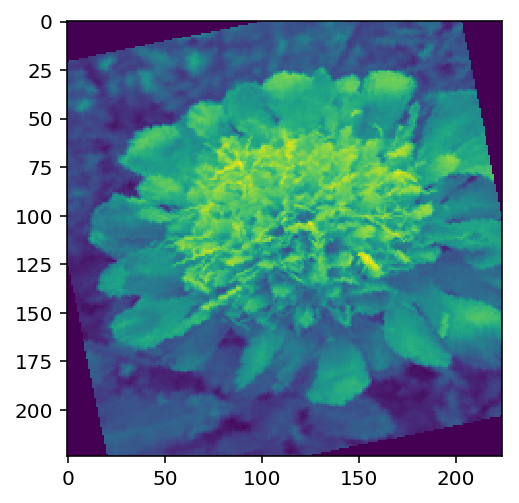

In [6]:
images, labels = next(iter(dataloaders["training"]))
print(len(images[0,2]))
plt.imshow(images[0,0])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things we'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [9]:
# Build and train the network
def get_model():
    model = models.densenet121(pretrained=True)
    return model

def build_model(hidden_layers, class_to_idx):
    model = get_model()
    for param in model.parameters():
        param.requires_grad = False
    
    classifier_input_size = model.classifier.in_features
    print("Input size: ", classifier_input_size)
    output_size = 102

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_layers)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_layers, output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
    model.classifier = classifier
    model.class_to_idx = class_to_idx
    return model

In [10]:
hidden_layers = 512
model = build_model(hidden_layers, class_to_idx)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 61451986.21it/s]


Input size:  1024


In [11]:
def train(model, epochs, learning_rate, criterion, optimizer, training_loader, validation_loader):
    
    model.train()
    print_every = 40
    steps = 0
    use_gpu = False
    
    if torch.cuda.is_available():
        use_gpu = True
        model.cuda()
    else:
        model.cpu()

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in iter(training_loader):
            steps += 1

            if use_gpu:
                inputs = Variable(inputs.float().cuda())
                labels = Variable(labels.long().cuda()) 
            else:
                inputs = Variable(inputs)
                labels = Variable(labels) 

            optimizer.zero_grad()
            output = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]

            if steps % print_every == 0:
                validation_loss, accuracy = validate(model, criterion, validation_loader)

                print("Epoch: {}/{} ".format(epoch+1, epochs),
                        "Training Loss: {:.3f} ".format(running_loss/print_every),
                        "Validation Loss: {:.3f} ".format(validation_loss),
                        "Validation Accuracy: {:.3f}".format(accuracy))

In [12]:
def validate(model, criterion, data_loader):
    model.eval()
    accuracy = 0
    test_loss = 0
    
    for inputs, labels in iter(data_loader):
        if torch.cuda.is_available():
            inputs = Variable(inputs.float().cuda(), volatile=True)
            labels = Variable(labels.long().cuda(), volatile=True) 
        else:
            inputs = Variable(inputs, volatile=True)
            labels = Variable(labels, volatile=True)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).data[0]
        ps = torch.exp(output).data 
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss/len(data_loader), accuracy/len(data_loader)

In [13]:
epochs = 9
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
train(model, epochs, learning_rate, criterion, optimizer, dataloaders['training'], dataloaders['validation'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Epoch: 1/9  Training Loss: 4.102  Validation Loss: 3.418  Validation Accuracy: 0.314
Epoch: 2/9  Training Loss: 0.725  Validation Loss: 1.405  Validation Accuracy: 0.687
Epoch: 2/9  Training Loss: 2.096  Validation Loss: 1.059  Validation Accuracy: 0.776
Epoch: 2/9  Training Loss: 3.275  Validation Loss: 0.918  Validation Accuracy: 0.787
Epoch: 3/9  Training Loss: 0.839  Validation Loss: 0.755  Validation Accuracy: 0.810
Epoch: 3/9  Training Loss: 1.707  Validation Loss: 0.725  Validation Accuracy: 0.819
Epoch: 4/9  Training Loss: 0.221  Validation Loss: 0.614  Validation Accuracy: 0.850
Epoch: 4/9  Training Loss: 0.986  Validation Loss: 0.607  Validation Accuracy: 0.850
Epoch: 4/9  Training Loss: 1.676  Validation Loss: 0.535  Validation Accuracy: 0.863
Epoch: 5/9  Training Loss: 0.468  Validation Loss: 0.564  Validation Accuracy: 0.849
Epoch: 5/9  Training Loss: 1.079  Validation Loss: 0.480  Validation Accuracy: 0.878
Epoch: 6/9  Training Loss: 0.080  Validation Loss: 0.476  Validat

## Testing our network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way we did validation. We should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# Performing validation on the test set
test_loss, accuracy = validate(model, criterion, dataloaders['testing'])
print("Val. Accuracy: {:.3f}".format(accuracy))
print("Val. Loss: {:.3f}".format(test_loss))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Val. Accuracy: 0.885
Val. Loss: 0.431


## Save the checkpoint

Now that our network is trained, we will save the model so that we can load it later for making predictions. We probably want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. We have to make sure to include any information we need in the checkpoint. If we want to load the model and keep training, we'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. We'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# Save the checkpoint 
checkpoint_path = 'densenet121_checkpoint.pth'

state = {
    'arch': 'densenet121',
    'learning_rate': learning_rate,
    'hidden_layers': hidden_layers,
    'epochs': epochs,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'class_to_idx' : model.class_to_idx
}

torch.save(state, checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [16]:
# Writing a function that loads a checkpoint and rebuilds the model
checkpoint_path = 'densenet121_checkpoint.pth'
state = torch.load(checkpoint_path)
learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']

model = build_model(hidden_layers, class_to_idx)

model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

print("Loaded '{}' (arch={}, hidden_layers={}, epochs={})".format(
    checkpoint_path, 
    state['arch'], 
    state['hidden_layers'], 
    state['epochs']))

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Input size:  1024
Loaded 'densenet121_checkpoint.pth' (arch=densenet121, hidden_layers=512, epochs=9)


# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. 

First we'll need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

We'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, we will resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    size = 224
    #Process a PIL image for use in a PyTorch model
    width, height = image.size
    
    if height > width:
        height = int(max(height * size / width, 1))
        width = int(size)
    else:
        width = int(max(width * size / height, 1))
        height = int(size)
        
    resized_image = image.resize((width, height))
        
    x0 = (width - size) / 2
    y0 = (height - size) / 2
    x1 = x0 + size
    y1 = y0 + size
    cropped_image = image.crop((x0, y0, x1, y1))
    np_image = np.array(cropped_image) / 255.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])     
    np_image_array = (np_image - mean) / std
    np_image_array = np_image.transpose((2, 0, 1))
    
    return np_image_array

To check the work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image.

In [18]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor we use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which hopefully we added to the model or from an `ImageFolder` we used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so we get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [19]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    use_gpu = False 
    if torch.cuda.is_available():
        use_gpu = True
        model = model.cuda()
    else:
        model = model.cpu()
    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)
    if use_gpu:
        var_inputs = Variable(tensor.float().cuda(), volatile=True)
    else:       
        var_inputs = Variable(tensor, volatile=True)
    var_inputs = var_inputs.unsqueeze(0)
    output = model.forward(var_inputs)  
    ps = torch.exp(output).data.topk(topk)
    probabilities = ps[0].cpu() if use_gpu else ps[0]
    classes = ps[1].cpu() if use_gpu else ps[1]
    class_to_idx_inverted = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    for label in classes.numpy()[0]:
        mapped_classes.append(class_to_idx_inverted[label])
    return probabilities.numpy()[0], mapped_classes

image_path = test_dir + '/13/image_05769.jpg'
probabilities, classes = predict(image_path, model)

print(probabilities)
print(classes)



[ 0.82906628  0.02716049  0.02089113  0.01763797  0.01562838]
['13', '73', '78', '57', '67']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


## Sanity Checking

Now that we can use a trained model for predictions, we need to check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. We can use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file. To show a PyTorch tensor as an image, use the `imshow` function defined above.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


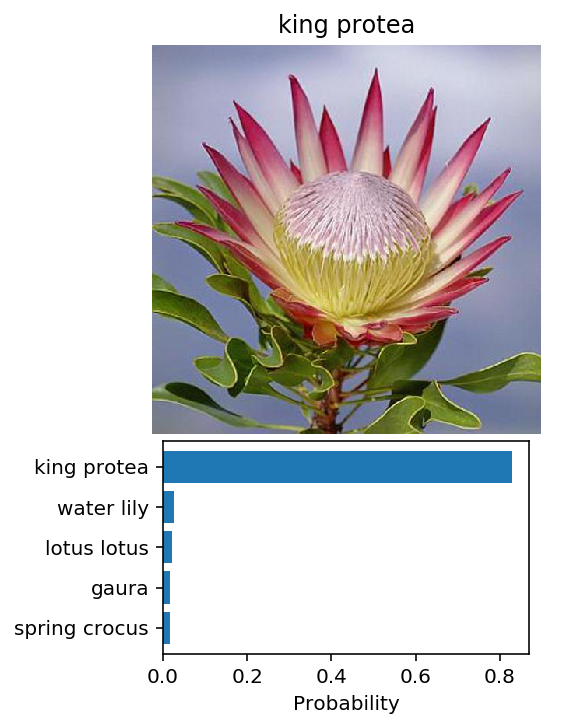

In [20]:
# Displaying an image along with the top 5 classes
image_path = test_dir + '/13/image_05769.jpg'
probabilitiess, classes = predict(image_path, model)
max_index = np.argmax(probabilities)
max_probability = probabilities[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)
labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()  # probabilities read top-to-bottom
ax2.set_xlabel('Probability')
ax2.barh(y_pos, probabilities, xerr=0, align='center')

plt.show()